In [1]:
import sagemaker
from sagemaker import get_execution_role
import pandas as pd 
import numpy as np
import calendar
import boto3

sess = sagemaker.Session()
role = get_execution_role()
pd.options.display.max_columns = None

### Download, uncompress and load datasets

In [2]:
!wget http://edzon.io/datasets/bike_share_dataset.zip -O bike_share_dataset.zip
!unzip -o bike_share_dataset.zip

--2019-10-23 20:33:28--  http://edzon.io/datasets/bike_share_dataset.zip
Resolving edzon.io (edzon.io)... 52.216.145.226
Connecting to edzon.io (edzon.io)|52.216.145.226|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227964 (223K) [application/zip]
Saving to: ‘bike_share_dataset.zip’

bike_share_dataset. 100%[===================>] 222.62K  --.-KB/s    in 0.004s  

2019-10-23 20:33:28 (55.3 MB/s) - ‘bike_share_dataset.zip’ saved [227964/227964]

Archive:  bike_share_dataset.zip
  inflating: bike_share_data.csv     
 extracting: seasons.csv             
  inflating: weathers.csv            
  inflating: weekdays.csv            


In [3]:
bike_share_df = pd.read_csv('bike_share_data.csv')
weathers_df = pd.read_csv('weathers.csv').set_index('id')
seasons_df = pd.read_csv('seasons.csv').set_index('id')
weekdays_df = pd.read_csv('weekdays.csv').set_index('id')

### Dataset columns
* **season:** Spring, Summer, Fall or Winter
* **holiday:** 1 - Yes, 0 - No
* **weekday:** Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday
* **workingday:** 1 - Yes, 0 - No
* **weather:** clear - Clear, Few clouds, Partly cloudy, Partly cloudy<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;misty_cloudy - Misty and Cloudy, Misty with Broken clouds, Misty with Few clouds, Misty<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ligth_rain_snow - Light Snow, Light Rain and Thunderstorm, Light Rain and Scatter clouds<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;heavy_rain_snow - Heavy Rain and Ice Pallets, Thunderstorm, Snow and Fog
* **temp:** Normalized temperature in Celsius
* **atemp:** Normalized feeling temperature in Celsius
* **humidity:** Normalized humidity
* **count:** Count of total rental bikes aggregated in one hour
* **datetime:** The hour and date

In [4]:
bike_share_df.head()


,season,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,count,datetime
0,fall,0,thursday,1,clear,0.58,0.5455,0.53,0.0896,190,2012-09-20 10:00:00
1,summer,0,friday,1,clear,0.70,0.6364,0.45,0.1642,830,2012-03-23 18:00:00
2,summer,0,friday,1,light_rain_snow,0.54,0.5152,0.52,0.3582,470,2011-05-06 18:00:00
3,summer,0,thursday,1,clear,0.70,0.6515,0.58,0.1045,289,2012-05-24 12:00:00
4,fall,0,saturday,0,misty_cloudy,0.72,0.6970,0.79,0.3582,566,2012-07-14 16:00:00


## Prepare dataset

Since fields: season, weekday and weather are categorical, we have to change to one hot encoding

#### One hot encoding

In [5]:
def one_hot_encoding(df, categories_df, column_name):
    categories = pd.api.types.CategoricalDtype(categories=categories_df.values.flatten())
    df[column_name]=df[column_name].astype(categories)
    df = pd.concat([df,pd.get_dummies(df[column_name],prefix=column_name)],axis=1)
    df.drop([column_name],axis=1, inplace=True)
    return df

In [6]:
bike_share_df = one_hot_encoding(bike_share_df,weathers_df,'weather')
bike_share_df = one_hot_encoding(bike_share_df,seasons_df,'season')
bike_share_df = one_hot_encoding(bike_share_df,weekdays_df,'weekday')
bike_share_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,datetime,weather_clear,weather_misty_cloudy,weather_light_rain_snow,weather_heavy_rain_snow,season_spring,season_summer,season_fall,season_winter,weekday_sunday,weekday_monday,weekday_tuesday,weekday_wednesday,weekday_thursday,weekday_friday,weekday_saturday
0,0,1,0.58,0.5455,0.53,0.0896,190,2012-09-20 10:00:00,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0,1,0.70,0.6364,0.45,0.1642,830,2012-03-23 18:00:00,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,1,0.54,0.5152,0.52,0.3582,470,2011-05-06 18:00:00,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,0,1,0.70,0.6515,0.58,0.1045,289,2012-05-24 12:00:00,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0.72,0.6970,0.79,0.3582,566,2012-07-14 16:00:00,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


#### Split date

In [7]:
def split_date(df, column_name):
    result = df
    result[column_name] = pd.to_datetime(df[column_name],infer_datetime_format=True)
    result['month']=result[column_name].dt.strftime('%b')
    result['hour']=result[column_name].dt.hour
    result.drop([column_name],axis=1, inplace=True)
    
    bike_share_df.loc[bike_share_df['hour'] < 12, 'time_of_day'] = 'Morning'
    bike_share_df.loc[(bike_share_df['hour'] >= 12) & (bike_share_df['hour'] < 17), 'time_of_day'] = 'Afternoon'
    bike_share_df.loc[bike_share_df['hour'] >= 17, 'time_of_day'] = 'Evening'
    result.drop(['hour'],axis=1, inplace=True)
    return result

In [8]:
bike_share_df = split_date(bike_share_df,'datetime')
bike_share_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,weather_clear,weather_misty_cloudy,weather_light_rain_snow,weather_heavy_rain_snow,season_spring,season_summer,season_fall,season_winter,weekday_sunday,weekday_monday,weekday_tuesday,weekday_wednesday,weekday_thursday,weekday_friday,weekday_saturday,month,time_of_day
0,0,1,0.58,0.5455,0.53,0.0896,190,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,Sep,Morning
1,0,1,0.70,0.6364,0.45,0.1642,830,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Mar,Evening
2,0,1,0.54,0.5152,0.52,0.3582,470,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,May,Evening
3,0,1,0.70,0.6515,0.58,0.1045,289,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,May,Afternoon
4,0,0,0.72,0.6970,0.79,0.3582,566,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,Jul,Afternoon


In [9]:
def encode_month(df, column_name):
    months = []
    for i in range(1,13):
        months.append((i, calendar.month_name[i][0:3]))
    months = pd.DataFrame(months, columns=['id','month'])
    months = months.set_index('id')
    return one_hot_encoding(df,months, column_name)

In [10]:
momentum

NameError: name 'momentum' is not defined

In [11]:
def encode_time(df, column_name):
    momentum = pd.DataFrame("Morning,Afternoon,Evening".split(','))
    return one_hot_encoding(df, momentum, column_name)

In [12]:
bike_share_df = encode_month(bike_share_df, 'month')
bike_share_df = encode_time(bike_share_df, 'time_of_day')
bike_share_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,weather_clear,weather_misty_cloudy,weather_light_rain_snow,weather_heavy_rain_snow,season_spring,season_summer,season_fall,season_winter,weekday_sunday,weekday_monday,weekday_tuesday,weekday_wednesday,weekday_thursday,weekday_friday,weekday_saturday,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Jul,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
0,0,1,0.58,0.5455,0.53,0.0896,190,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0,1,0.70,0.6364,0.45,0.1642,830,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0.54,0.5152,0.52,0.3582,470,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,1,0.70,0.6515,0.58,0.1045,289,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0,0,0.72,0.6970,0.79,0.3582,566,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


#### Move target to first column

In [13]:
def move_target(df,target):
    target_column = df[target]
    df.drop([target], axis=1, inplace = True)
    df.insert(0,target,target_column)
    return df

In [14]:
bike_share_df = move_target(bike_share_df,'count')
bike_share_df.head()

,count,holiday,workingday,temp,atemp,humidity,windspeed,weather_clear,weather_misty_cloudy,weather_light_rain_snow,weather_heavy_rain_snow,season_spring,season_summer,season_fall,season_winter,weekday_sunday,weekday_monday,weekday_tuesday,weekday_wednesday,weekday_thursday,weekday_friday,weekday_saturday,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Jul,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
0,190,0,1,0.58,0.5455,0.53,0.0896,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,830,0,1,0.70,0.6364,0.45,0.1642,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,470,0,1,0.54,0.5152,0.52,0.3582,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,289,0,1,0.70,0.6515,0.58,0.1045,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,566,0,0,0.72,0.6970,0.79,0.3582,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


#### Split into training and validation

In [15]:
def train_val_split(df, train_size, val_size):
    return np.split(df.sample(frac=1), [int(train_size*len(df)),int((train_size+val_size)*len(df))])

In [16]:
train_df, val_df, test_df = train_val_split(bike_share_df, .7, .2)
train_file = 'train_data.csv'
val_file = 'val_data.csv'
test_file = 'test_data.csv'
train_df.to_csv(train_file, index=False, header=False)
val_df.to_csv(val_file, index=False, header=False)
test_df.to_csv(test_file, index=False, header=False)

### Upload to S3

In [17]:
def upload_to_s3(bucket, prefix, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = '{}/{}'.format(prefix, file)
    s3.Bucket(bucket).put_object(Key=key, Body=data, ContentType='text/csv')
    path = 's3://{}/{}'.format(bucket, key)
    print(path)
    return path

def create_data_channels(train_file, val_file, test_file):
    s3_train_data = upload_to_s3(bucket,'{}/train'.format(prefix),train_file)
    s3_val_data = upload_to_s3(bucket,'{}/val'.format(prefix),val_file)
    s3_test_data = upload_to_s3(bucket,'{}/test'.format(prefix),test_file)
    
    train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                                        content_type='text/csv', s3_data_type='S3Prefix')
    val_data = sagemaker.session.s3_input(s3_val_data, distribution='FullyReplicated', 
                                        content_type='text/csv', s3_data_type='S3Prefix')
    test_data = sagemaker.session.s3_input(s3_test_data, distribution='FullyReplicated', 
                                        content_type='text/csv', s3_data_type='S3Prefix')
    
    return {'train': train_data, 'validation': val_data, 'test': test_data}

In [18]:
bucket = 'ml-mx-dacc'
prefix = 'sagemaker/Lab-linear-learner'
output_location = 's3://{}/{}/output'.format(bucket, prefix)

### Train the model

In [22]:
data_channels = create_data_channels(train_file, val_file, test_file)


s3://ml-mx-dacc/sagemaker/Lab-linear-learner/train/train_data.csv
s3://ml-mx-dacc/sagemaker/Lab-linear-learner/val/val_data.csv
s3://ml-mx-dacc/sagemaker/Lab-linear-learner/test/test_data.csv


In [23]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')


In [24]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c5.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)

linear.set_hyperparameters(feature_dim=len(train_df.columns)-1,
                           predictor_type='regressor',
                           early_stopping_patience=50,
                           epochs=120,                           
                           learning_rate='auto',
                           loss='squared_loss',
                           optimizer='sgd',
                           mini_batch_size=100)

linear.fit(inputs=data_channels, logs=True)

2019-10-23 20:40:42 Starting - Starting the training job...
2019-10-23 20:40:44 Starting - Launching requested ML instances......
2019-10-23 20:41:48 Starting - Preparing the instances for training...
2019-10-23 20:42:38 Downloading - Downloading input data...
2019-10-23 20:43:09 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[10/23/2019 20:43:11 INFO 140506443372352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'au

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6581698794404337, "sum": 0.6581698794404337, "min": 0.6581698794404337}}, "EndTime": 1571863402.299728, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1571863402.299681}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6561137011819634, "sum": 0.6561137011819634, "min": 0.6561137011819634}}, "EndTime": 1571863402.299785, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1571863402.299777}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6579822663236256, "sum": 0.6579822663236256, "min": 0.6579822663236256}}, "EndTime": 1571863402.299818, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1571863402.299812}

#metrics {"Metrics": {"train_mse_objective": {

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6540280397273293, "sum": 0.6540280397273293, "min": 0.6540280397273293}}, "EndTime": 1571863412.469215, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1571863412.469166}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6526436841980485, "sum": 0.6526436841980485, "min": 0.6526436841980485}}, "EndTime": 1571863412.469271, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1571863412.469263}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6548298764819941, "sum": 0.6548298764819941, "min": 0.6548298764819941}}, "EndTime": 1571863412.469303, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1571863412.469297}

#metrics {"Metrics": {"train_mse_objective"

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6529431177564889, "sum": 0.6529431177564889, "min": 0.6529431177564889}}, "EndTime": 1571863422.696343, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1571863422.696297}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6517630231873063, "sum": 0.6517630231873063, "min": 0.6517630231873063}}, "EndTime": 1571863422.696399, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1571863422.696391}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6538293992980453, "sum": 0.6538293992980453, "min": 0.6538293992980453}}, "EndTime": 1571863422.696442, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1571863422.696432}

#metrics {"Metrics": {"train_mse_objective"

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6525271827130278, "sum": 0.6525271827130278, "min": 0.6525271827130278}}, "EndTime": 1571863432.561928, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1571863432.561881}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6513588465540863, "sum": 0.6513588465540863, "min": 0.6513588465540863}}, "EndTime": 1571863432.561985, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1571863432.561977}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6534165982963626, "sum": 0.6534165982963626, "min": 0.6534165982963626}}, "EndTime": 1571863432.562066, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1571863432.562055}

#metrics {"Metrics": {"train_mse_objective"

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6523453162327285, "sum": 0.6523453162327285, "min": 0.6523453162327285}}, "EndTime": 1571863442.376383, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 29}, "StartTime": 1571863442.376334}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6511089586620489, "sum": 0.6511089586620489, "min": 0.6511089586620489}}, "EndTime": 1571863442.376442, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 29}, "StartTime": 1571863442.376434}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6532306696363717, "sum": 0.6532306696363717, "min": 0.6532306696363717}}, "EndTime": 1571863442.376477, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 29}, "StartTime": 1571863442.376469}

#metrics {"Metrics": {"train_mse_objective"

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6522614376604065, "sum": 0.6522614376604065, "min": 0.6522614376604065}}, "EndTime": 1571863452.660542, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 35}, "StartTime": 1571863452.660492}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6509331351666411, "sum": 0.6509331351666411, "min": 0.6509331351666411}}, "EndTime": 1571863452.660599, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 35}, "StartTime": 1571863452.66059}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6531459244026625, "sum": 0.6531459244026625, "min": 0.6531459244026625}}, "EndTime": 1571863452.660634, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 35}, "StartTime": 1571863452.660625}

#metrics {"Metrics": {"train_mse_objective":

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6522218656933997, "sum": 0.6522218656933997, "min": 0.6522218656933997}}, "EndTime": 1571863462.615191, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 41}, "StartTime": 1571863462.615143}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6507997471833032, "sum": 0.6507997471833032, "min": 0.6507997471833032}}, "EndTime": 1571863462.615247, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 41}, "StartTime": 1571863462.615239}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6530801419975344, "sum": 0.6530801419975344, "min": 0.6530801419975344}}, "EndTime": 1571863462.61528, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 41}, "StartTime": 1571863462.615274}

#metrics {"Metrics": {"train_mse_objective":

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6522029804198209, "sum": 0.6522029804198209, "min": 0.6522029804198209}}, "EndTime": 1571863472.431337, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 47}, "StartTime": 1571863472.431288}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6506929006655354, "sum": 0.6506929006655354, "min": 0.6506929006655354}}, "EndTime": 1571863472.431393, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 47}, "StartTime": 1571863472.431385}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6530161704701826, "sum": 0.6530161704701826, "min": 0.6530161704701826}}, "EndTime": 1571863472.431429, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 47}, "StartTime": 1571863472.431421}

#metrics {"Metrics": {"train_mse_objective"

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6521942403493834, "sum": 0.6521942403493834, "min": 0.6521942403493834}}, "EndTime": 1571863482.519435, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 53}, "StartTime": 1571863482.519387}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.6506045352525948, "sum": 0.6506045352525948, "min": 0.6506045352525948}}, "EndTime": 1571863482.51949, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 53}, "StartTime": 1571863482.519483}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.652953923122942, "sum": 0.652953923122942, "min": 0.652953923122942}}, "EndTime": 1571863482.519527, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 53}, "StartTime": 1571863482.519518}

#metrics {"Metrics": {"train_mse_objective": {"


2019-10-23 20:44:58 Uploading - Uploading generated training model
2019-10-23 20:44:58 Completed - Training job completed
Training seconds: 140
Billable seconds: 140


### Deploy the model

In [25]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

---------------------------------------------------------------------------------------!

### Realtime inference

In [26]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [27]:
result = linear_predictor.predict(train_df.iloc[20].drop(['count']))
print("prediction: {}".format(result['predictions'][0]['score']))

prediction: 37.28215789794922


In [28]:
def plot_actual_vs_prediction(df, predictor):
    labels = []
    predictions = []
    target_column = df.columns[0]
    for index, row in df.iterrows():
        labels.append(row[target_column])
        predictions.append(predictor.predict(row.drop(target_column))['predictions'][0]['score'])
    
    %matplotlib inline

    import matplotlib
    import matplotlib.pyplot as plt
    matplotlib.rcParams['figure.dpi'] = 100

    plt.plot(np.array(labels),label='actual')
    plt.plot(np.array(predictions),label='prediction')
    plt.legend()
    plt.show()

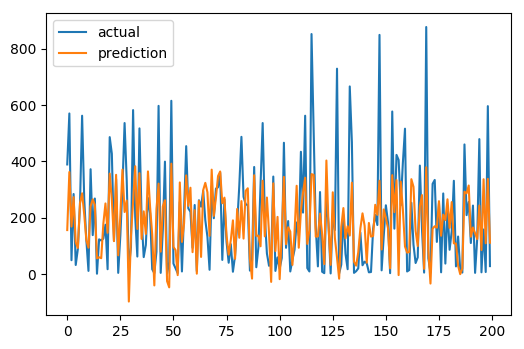

In [29]:
plot_actual_vs_prediction(val_df.sample(n=200), linear_predictor)